In [1]:
import base64
from importlib import reload
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import shutil
from tensorboardX import SummaryWriter
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
from a3c import A3CVectorized
import graph_nns as gnn
import vectorized_env as ve
import vectorized_agents as va

%matplotlib inline
jtplot.style()
pd.set_option('display.max_rows', 150)

DEVICE = torch.device('cuda')
OBS_NORM = 100. / 1999.

if DEVICE == torch.device('cpu'):
    os.environ['OMP_NUM_THREADS'] = '4'
else:
    os.environ['OMP_NUM_THREADS'] = '16'

## Load a saved model state_dict from a serialized string file

In [6]:
graph_nn_kwargs = dict(
    n_hidden_layers=8,
    layer_sizes=32,
    layer_class=gnn.SmallFullyConnectedGNNLayer,
    skip_connection_n=1,
    normalize=True
)

model = gnn.GraphNNActorCritic(
    in_features=4,
    n_nodes=100,
    **graph_nn_kwargs
)
run_folder = 'awac/small_8_32_1_norm_v1/'
model_checkpoint = '160'
with open(f'runs/{run_folder}/{model_checkpoint}_cp.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)
model.load_state_dict(loaded_state_dicts['model_state_dict'])
model.to(device=DEVICE)
model.eval()
model_wrapped = va.RLModelWrapperAgent(model, ve.SUMMED_OBS, name=f'new_model checkpoint #{model_checkpoint}', deterministic_policy=True)


benchmark_env_kwargs = dict(
    n_envs=500 if DEVICE == torch.device('cuda') else 50,
    env_device=DEVICE,
    out_device=DEVICE,
    obs_type=ve.SUMMED_OBS_WITH_TIMESTEP
)
important_env_kwargs = dict(**benchmark_env_kwargs)
important_env_kwargs['n_envs'] = benchmark_env_kwargs['n_envs'] * 5

rl_agent_opp_kwargs = dict(
    device=DEVICE,
    deterministic_policy=True
)

In [3]:
test_env = ve.KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97, obs_type=ve.SUMMED_OBS_WITH_TIMESTEP)
with torch.no_grad():
    s, _, _, _ = test_env.reset()
    # Take n good actions
    for i in range(500):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
        _, v = model(s[0,0].to(device=DEVICE)[None, None, :])
        if i % 50 == 0:
            print(f'{v.item():.3f}')
    logits, values = model(s[0,0].to(device=DEVICE)[None, None, :])
    probs = F.softmax(logits, dim=-1).cpu().numpy().squeeze()
    probs = np.where(
        probs < 0.01,
        0,
        probs
    )
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(probs)
print(values)
print(s[:,0].squeeze().t() / OBS_NORM)

0.310
1.582
1.482
1.285
1.276
1.403
1.618
1.983
1.913
1.991

[ -2.3669555   -4.1008353   -0.7891669   -2.3669555   -2.90896
  -2.3669555   -1.9207996    4.714691    -4.3157973   -1.977232
  -2.366955    -2.366955     1.3066248   -2.3669548   -2.3669548
  -2.3669565   -3.0221136   -2.3669548   -4.4325852   -0.2650433
  -2.3669548    1.3066252    3.552179     0.55906194  -4.5504923
   5.2732983   -2.366956    -2.366956    -2.366956    -2.366956
  -2.366956    -2.3669553   -0.44745153  -2.366956    -2.3669555
  -2.3669558   -1.9207996    0.48640454  -4.3853493    2.6291113
   2.764362    -4.176585    -9.131114    -2.366956     2.733421
  -1.5604694   -2.3669555   -2.3669565   -2.3669548    3.1771448
  -2.366955   -12.099678    -1.9207999   -0.78916705  -2.3669543
  -2.3669543   -4.675004    -2.366956    -2.366956    -3.1715558
  -2.366956    -3.0221138   -3.802272    -2.3669553   -2.3669558
   0.32634157  -3.5347834    4.646613    -2.9742434   -2.3669558
  -4.1945305   -1.5280375   -2.366

## Benchmark the model against a previous RL agent, and various hand-crafted algorithms

In [ ]:
# Against itself
#va.run_vectorized_vs(model_wrapped, model_wrapped, **benchmark_env_kwargs)

## Basic thompson sampling
va.run_vectorized_vs(model_wrapped, va.BasicThompsonSampling(OBS_NORM), **benchmark_env_kwargs)

## Pull vegas slot machines
va.run_vectorized_vs(model_wrapped, va.PullVegasSlotMachines(OBS_NORM), **benchmark_env_kwargs)

## Previous best models
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v0', **rl_agent_opp_kwargs), **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v1', **rl_agent_opp_kwargs), **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v2', **rl_agent_opp_kwargs), **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3', **rl_agent_opp_kwargs), **benchmark_env_kwargs)

In [7]:
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v4-162', **rl_agent_opp_kwargs), **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_small_8_32-790', **rl_agent_opp_kwargs), **important_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('awac_agent_4_20_1_norm_v1-215', **rl_agent_opp_kwargs), opponent_obs_type=ve.SUMMED_OBS_WITH_TIMESTEP, **important_env_kwargs)

100%|██████████| 1999/1999 [00:47<00:00, 42.19it/s]


Wrapped RL model: new_model checkpoint #160 -vs- SavedRLAgent: a3c_agent_v4-162
Mean scores: 639.17 - 632.89
Match score: 287 - 11 - 202 (57.4% - 2.2% - 40.4%)


100%|██████████| 1999/1999 [01:43<00:00, 19.25it/s]


Wrapped RL model: new_model checkpoint #160 -vs- SavedRLAgent: a3c_agent_small_8_32-790
Mean scores: 641.21 - 637.69
Match score: 1369 - 32 - 1099 (54.8% - 1.3% - 44.0%)


100%|██████████| 1999/1999 [02:15<00:00, 14.76it/s]


Wrapped RL model: new_model checkpoint #160 -vs- SavedRLAgent: awac_agent_4_20_1_norm_v1-215
Mean scores: 633.43 - 647.96
Match score: 790 - 27 - 1683 (31.6% - 1.1% - 67.3%)


## A3C: use self-play records to see which version was the strongest

In [2]:
run_folder = 'a3c/small_16_32_v2'
vs_df = pd.read_csv(f'runs/{run_folder}/final_466_skill_estimates.csv')
vs_df.sort_values('est_opp_skill')

,Unnamed: 0,opp_a,opp_b,est_opp_skill,checkpoint_idxs
0,0,1.627237,11.763075,0.121523,NaN
1,1,8.090940,21.223019,0.276010,NaN
29,29,7.458026,16.088277,0.316739,23.0
43,43,12.923433,21.372566,0.376820,37.0
51,51,9.497470,14.593674,0.394231,45.0
23,23,10.202497,14.882481,0.406717,17.0
37,37,13.683837,19.700724,0.409885,31.0
18,18,25.465700,36.501618,0.410954,12.0
4,4,21.111112,27.344973,0.435675,NaN
27,27,21.932258,28.309579,0.436534,21.0


## Visualize model parameter distributions

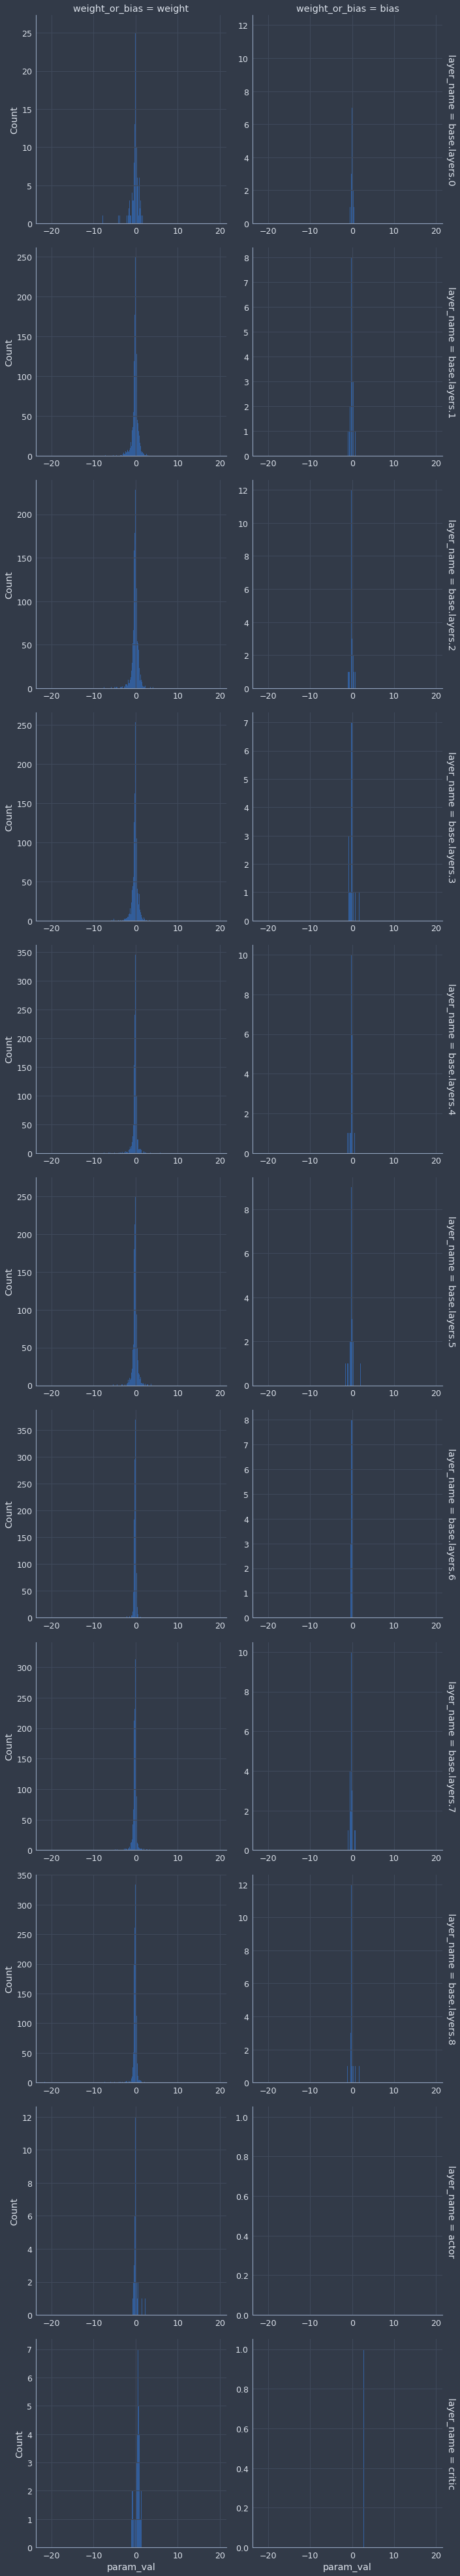

In [4]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='weight_or_bias', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [ ]:
model.to('cpu')pd.set_option('display.max_rows', 500)
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))
model.to(device=DEVICE);

## Testing and debugging

In [ ]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

In [ ]:
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=DEVICE)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

In [ ]:
# Simulated env rollouts with random policy
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
# Simulated env rollouts with omniscient optimal policy
test_env = ve.KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

In [ ]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

In [ ]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

In [ ]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

## Deprecated

In [ ]:
# Loosely based on: https://github.com/MorvanZhou/pytorch-A3C
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=DEVICE)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=DEVICE).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=DEVICE).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=DEVICE)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=DEVICE),
                    torch.stack(buffer_a).to(device=DEVICE),
                    torch.stack(buffer_v_target).to(device=DEVICE)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
    return episode_reward_sums

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [ ]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss